## 1. 목표 정의 및 개요
- 목표 : 고객 데이터를 활용해 운전자가 보험을 청구할 확률 예측
- 평가 기준 : 정규화된 지니계수
- 제출 형식 : id, 보험금 청구 확률

## 2. 탐색적 데이터 분석
1. 데이터 둘러보기
- 피처 요약표
2. 데이터 시각화
- 각종 피처의 분포 확인(타깃값, 이진 피처, 명목형 피처, 순서형 피처, 연속형 피처)
3. 분석 정리 및 모델링 전략

### 2-1 데이터 둘러보기 

In [97]:
import pandas as pd

data_path = 'C:/workspace/kaggle/safe_driver_prediction/data/'

train = pd.read_csv(data_path + 'train.csv', index_col = 'id')
test = pd.read_csv(data_path + 'test.csv', index_col = 'id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col = 'id')

In [98]:
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [99]:
test.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,8,1,0,0,1,0,0,0,...,1,1,1,12,0,1,1,0,0,1
1,4,2,5,1,0,0,0,0,1,0,...,2,0,3,10,0,0,1,1,0,1
2,5,1,3,0,0,0,0,0,1,0,...,4,0,2,4,0,0,0,0,0,0
3,0,1,6,0,0,1,0,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,5,1,7,0,0,0,0,0,1,0,...,4,0,0,4,0,1,1,0,0,1


In [100]:
print(train.shape)
print(test.shape)

(595212, 58)
(892816, 57)


In [101]:
submission.head()

,target
id,
0,0.0364
1,0.0364
2,0.0364
3,0.0364
4,0.0364


In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

ps_[분류]_ [일련번호]_[데이터 종류]
- 분류 : ind, reg, car
- 데이터 종류 : bin(이진), cat(명목형), 생략(연속적 또는 순서)
- 각 값에서 -1은 결측값을 의미     
=> -1을 np.NaN으로 변환하여 확인

#### 결측값 시각화하기
- missingno 패키지 사용

In [103]:
import numpy as np
import missingno as msno

train_copy = train.copy().replace(-1,np.NaN)

train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   594996 non-null  float64
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595129 non-null  float64
 5   ps_ind_05_cat   589403 non-null  float64
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

#### bar 그래프를 이용하여 결측값 시각화

<AxesSubplot:>

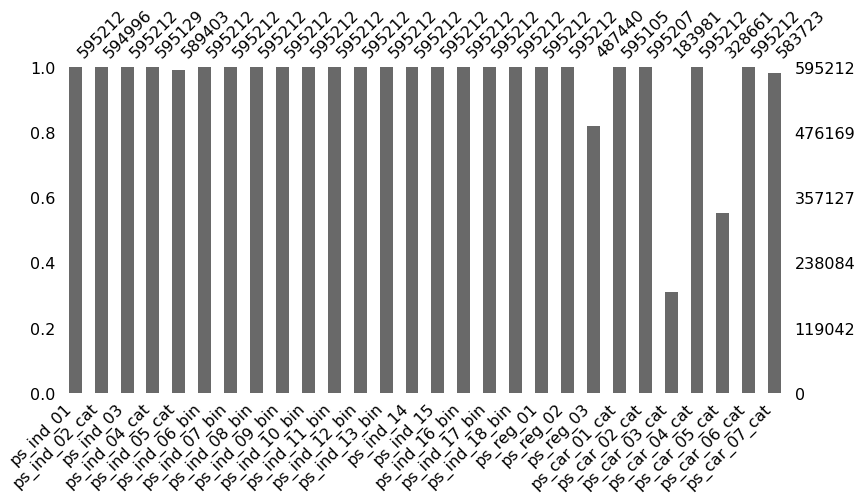

In [104]:
# 처음 28개만 결측값 시각화
msno.bar(df = train_copy.iloc[:,1:29], figsize=(13,6))

=> ps_reg_03, ps_car_03_cat, ps_car_05_cat 피처에 결측값이 많음

<AxesSubplot:>

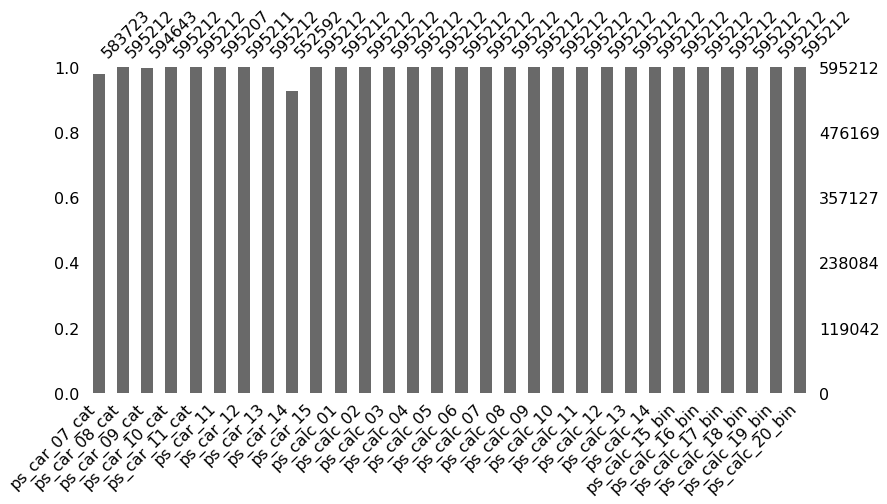

In [105]:
msno.bar(df = train_copy.iloc[:,28:], figsize=(13,6))

#### 매트릭스 형태로 결측값 시각화

<AxesSubplot:>

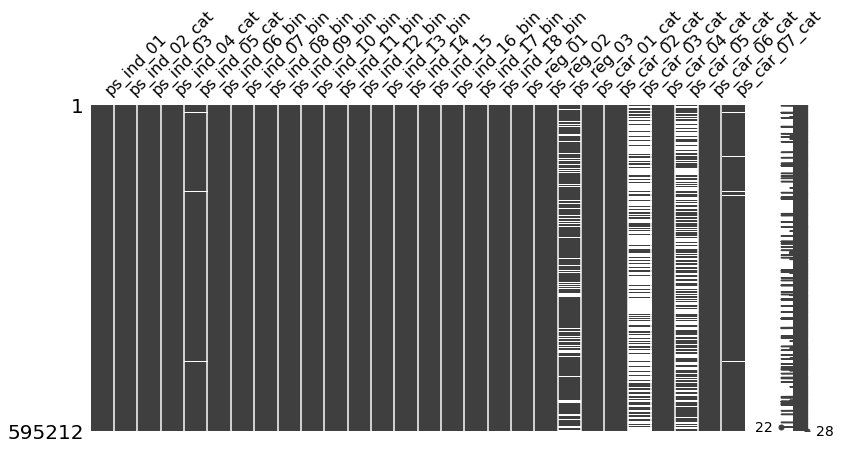

In [106]:
msno.matrix(df = train_copy.iloc[:,1:29], figsize=(13,6))

<AxesSubplot:>

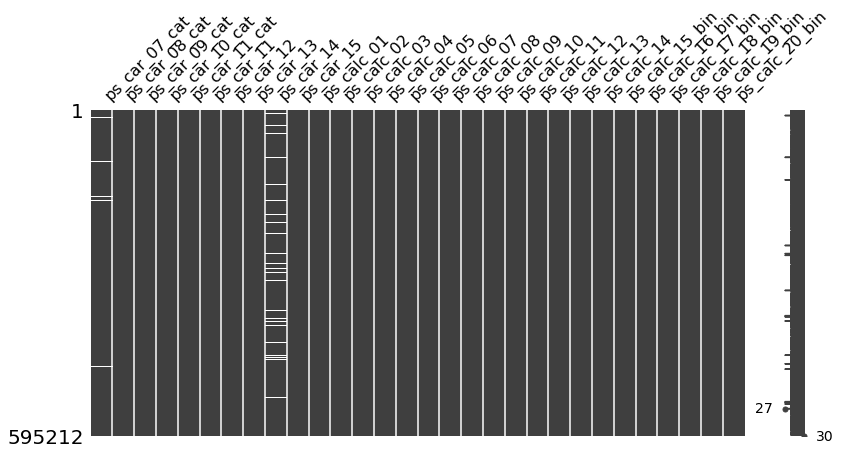

In [107]:
msno.matrix(df = train_copy.iloc[:,28:], figsize=(13,6))

- 맨 오른쪽 그림에서 검은색으로 뾰족하게 튀어나온 부분이 결측값이 몰려잏는 행을 의미
- 하단의 숫자에서 왼쪽은 결측값이 없는 열의 개수를, 오른쪽은 전체 열 개수를 뜻함

#### 피처 요약표

In [108]:
feature_df = pd.DataFrame(train.dtypes, columns = ['데이터 타입'])
feature_df['결측값 개수'] = (train==-1).sum().values
feature_df['고윳값 개수'] = train.nunique().values
feature_df

,데이터 타입,결측값 개수,고윳값 개수
target,int64,0,2
ps_ind_01,int64,0,8
ps_ind_02_cat,int64,216,5
ps_ind_03,int64,0,12
ps_ind_04_cat,int64,83,3
ps_ind_05_cat,int64,5809,8
ps_ind_06_bin,int64,0,2
ps_ind_07_bin,int64,0,2
ps_ind_08_bin,int64,0,2
ps_ind_09_bin,int64,0,2


In [109]:
for column in train.columns:
    if 'bin' in column or column == 'target':
        feature_df.loc[column, '데이터 종류'] = '이진형'
    elif 'cat' in column:
        feature_df.loc[column, '데이터 종류'] = '명목형'
    elif train[column].dtype == float:
        feature_df.loc[column, '데이터 종류'] = '연속형'
    elif train[column].dtype == 'int64':
        feature_df.loc[column, '데이터 종류'] = '순서형'

In [110]:
feature_df

,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
target,int64,0,2,이진형
ps_ind_01,int64,0,8,순서형
ps_ind_02_cat,int64,216,5,명목형
ps_ind_03,int64,0,12,순서형
ps_ind_04_cat,int64,83,3,명목형
ps_ind_05_cat,int64,5809,8,명목형
ps_ind_06_bin,int64,0,2,이진형
ps_ind_07_bin,int64,0,2,이진형
ps_ind_08_bin,int64,0,2,이진형
ps_ind_09_bin,int64,0,2,이진형


In [111]:
train

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488013,0,3,1,10,0,0,0,0,0,1,...,4,1,9,6,0,1,1,0,1,1
1488016,0,5,1,3,0,0,0,0,0,1,...,4,1,3,8,1,0,1,0,1,1
1488017,0,1,1,10,0,0,1,0,0,0,...,3,2,2,6,0,0,1,0,0,0


#### 피처 요약표 함수화

In [112]:
def resumetable(df):
    summary = pd.DataFrame(df.dtypes, columns = ['데이터 타입'])
    summary['결측값 개수'] = (df==-1).sum().values
    summary['고윳값 개수'] = df.nunique().values
    
    for column in df.columns:
        if 'bin' in column or column == 'target':
            summary.loc[column, '데이터 종류'] = '이진형'
        elif 'cat' in column:
            summary.loc[column, '데이터 종류'] = '명목형'
        elif df[column].dtype == float:
            summary.loc[column, '데이터 종류'] = '연속형'
        elif df[column].dtype == 'int64':
            summary.loc[column, '데이터 종류'] = '순서형'
            
    return summary

In [113]:
summary = resumetable(train)
summary

,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
target,int64,0,2,이진형
ps_ind_01,int64,0,8,순서형
ps_ind_02_cat,int64,216,5,명목형
ps_ind_03,int64,0,12,순서형
ps_ind_04_cat,int64,83,3,명목형
ps_ind_05_cat,int64,5809,8,명목형
ps_ind_06_bin,int64,0,2,이진형
ps_ind_07_bin,int64,0,2,이진형
ps_ind_08_bin,int64,0,2,이진형
ps_ind_09_bin,int64,0,2,이진형


In [114]:
summary[summary['데이터 종류']=='명목형'].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

### 2-2 데이터 시각화
- 모델링에 도움이 되는 피처 찾기      
1. 고윳값 별로 타깃값이 1인 비율이 차이가 나야함     
2. 통계적 유효성이 있어야 함(신뢰구간이 크지 않아야 함)

In [115]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

#### 타깃값 분포 그래프 함수

In [116]:
def write_percent(ax, total_size):
    for patch in ax.patches:
        height = patch.get_height()
        width = patch.get_width()
        left_coord = patch.get_x()
        percent = height/total_size * 100
        
        ax.text(left_coord + width/2, height + total_size*0.001, '{:1.1f}%'.format(percent),ha='center')

Text(0.5, 1.0, 'Target Distribution')

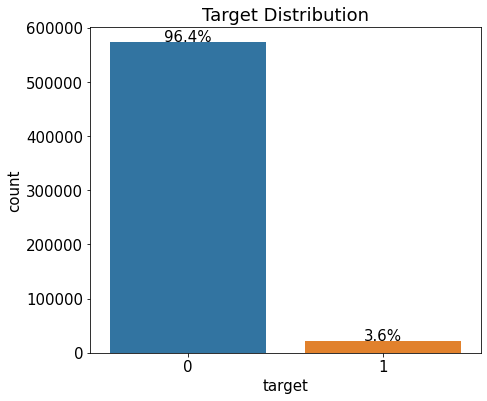

In [117]:
mpl.rc('font', size=15)
plt.figure(figsize=(7,6))

ax = sns.countplot(x='target', data=train)
write_percent(ax, len(train))
ax.set_title('Target Distribution')

=> 전체 운전자 중 3.6%만 보험금을 청구       
=> 타깃값이 불균형하므로 비율이 작은 타깃값(1)을 잘 예측하는 것이 중요      
=> 각 피처의 고윳값별 타깃값 1의 비율 을 알아본 후 해당 피처가 모델링에 필요한 지 확인!

#### 이진 피처

In [118]:
summary = resumetable(train)
summary[summary['데이터 종류']=='이진형']

,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
target,int64,0,2,이진형
ps_ind_06_bin,int64,0,2,이진형
ps_ind_07_bin,int64,0,2,이진형
ps_ind_08_bin,int64,0,2,이진형
ps_ind_09_bin,int64,0,2,이진형
ps_ind_10_bin,int64,0,2,이진형
ps_ind_11_bin,int64,0,2,이진형
ps_ind_12_bin,int64,0,2,이진형
ps_ind_13_bin,int64,0,2,이진형
ps_ind_16_bin,int64,0,2,이진형


<AxesSubplot:xlabel='ps_ind_06_bin', ylabel='target'>

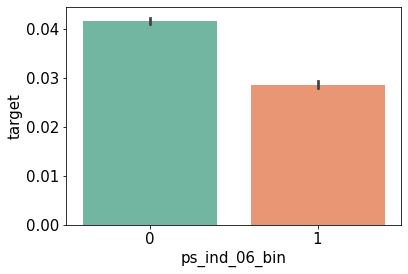

In [119]:
sns.barplot(x='ps_ind_06_bin',y='target',data=train, palette='Set2')

In [120]:
summary[summary['데이터 종류']=='명목형']

,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
ps_ind_02_cat,int64,216,5,명목형
ps_ind_04_cat,int64,83,3,명목형
ps_ind_05_cat,int64,5809,8,명목형
ps_car_01_cat,int64,107,13,명목형
ps_car_02_cat,int64,5,3,명목형
ps_car_03_cat,int64,411231,3,명목형
ps_car_04_cat,int64,0,10,명목형
ps_car_05_cat,int64,266551,3,명목형
ps_car_06_cat,int64,0,18,명목형
ps_car_07_cat,int64,11489,3,명목형


<AxesSubplot:xlabel='ps_ind_02_cat', ylabel='target'>

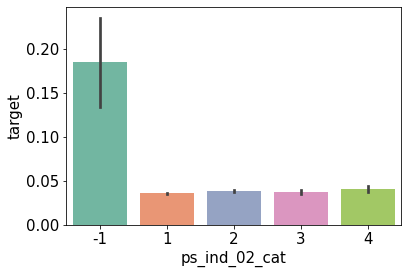

In [121]:
sns.barplot(x='ps_ind_02_cat',y='target',data=train, palette='Set2')

#### 피처의 고윳값별 타깃값이 1인 비율을 구하는 함수

In [122]:
import matplotlib.gridspec as gridspec

def plot_target_ratio_by_features(df, features, num_rows, num_cols, size=(12, 18)):
    mpl.rc('font', size=9)
    plt.figure(figsize=size)
    grid = gridspec.GridSpec(num_rows, num_cols)
    # 서브플롯 좌우/상하 여백 설정
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        sns.barplot(x=feature,y='target',data=df, palette='Set2', ax=ax)

In [123]:
bin_features = summary[summary['데이터 종류']=='이진형'].index
bin_features

Index(['target', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],
      dtype='object')

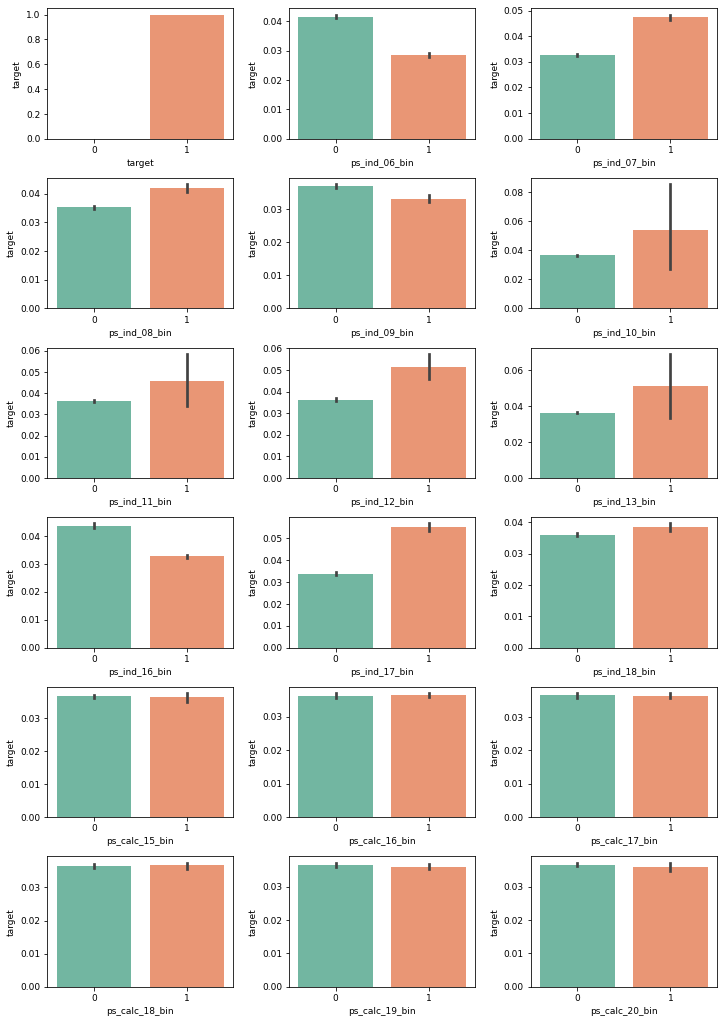

In [124]:
plot_target_ratio_by_features(train, bin_features, 6,3)

#### 제거해야 할 이진 피처
- ps_ind_10_bin ~ ps_ind_13_bin => 신뢰구간이 넓어 통계적 유효성이 떨어짐
- ps_calc_15_bin ~ ps_calc_20_bin => 고윳값별 타깃값 비율 차이가 없음(타깃값 예측력이 없음)

#### 명목형 피처

In [125]:
cat_features = summary[summary['데이터 종류']=='명목형'].index
cat_features

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

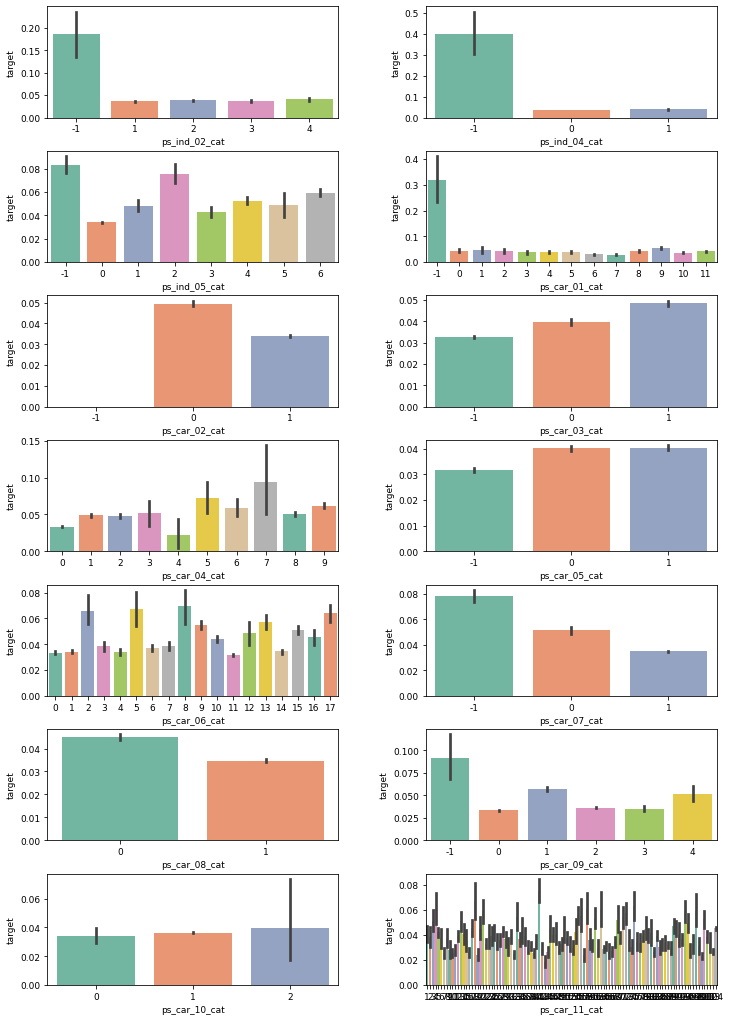

In [126]:
plot_target_ratio_by_features(train, cat_features, 7,2)

- 결측값인 -1도 하나의 고윳값으로 간주!!!                          
- ps_ind_02_cat, ps_ind_04_cat, ps_car_01_cat의 경우 신뢰구간이 넓지만 -1의 신뢰하한과 다른 고윳값들의 신뢰상한 간 차이가 크므로 해당 피처를 제거하지 않음!

#### 순서형 피처

In [127]:
summary

,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
target,int64,0,2,이진형
ps_ind_01,int64,0,8,순서형
ps_ind_02_cat,int64,216,5,명목형
ps_ind_03,int64,0,12,순서형
ps_ind_04_cat,int64,83,3,명목형
ps_ind_05_cat,int64,5809,8,명목형
ps_ind_06_bin,int64,0,2,이진형
ps_ind_07_bin,int64,0,2,이진형
ps_ind_08_bin,int64,0,2,이진형
ps_ind_09_bin,int64,0,2,이진형


In [128]:
ord_features = summary[summary['데이터 종류']=='순서형'].index
print(len(ord_features))
ord_features

16


Index(['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_car_11',
       'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08',
       'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13',
       'ps_calc_14'],
      dtype='object')

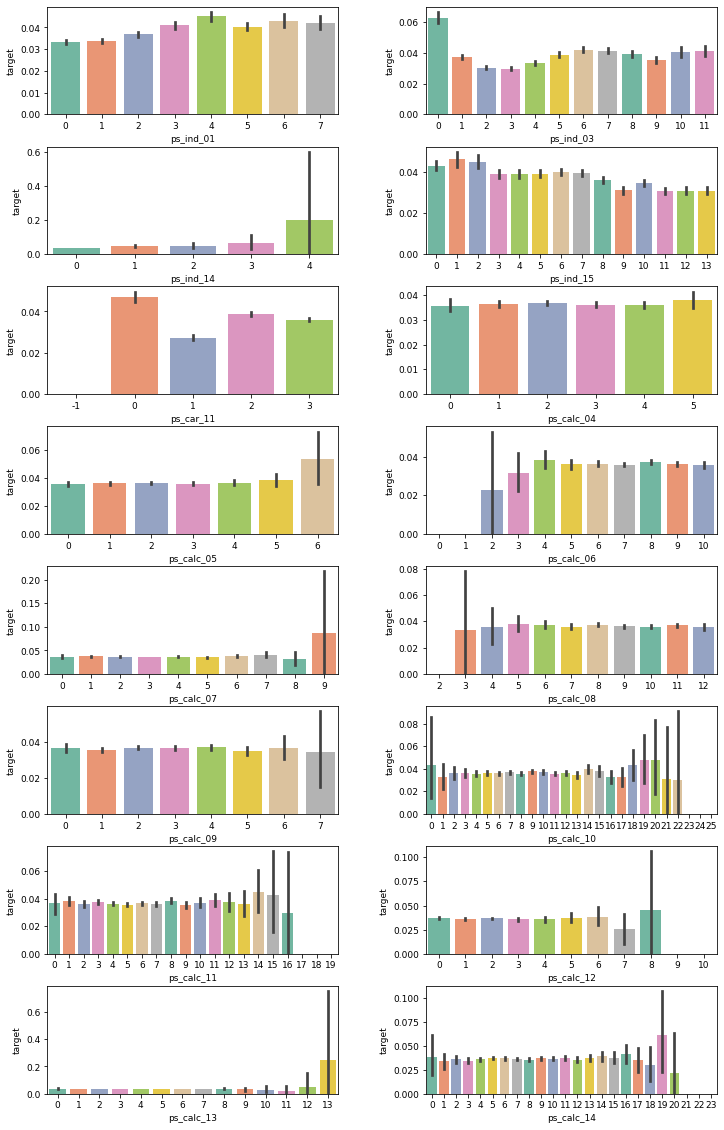

In [129]:
plot_target_ratio_by_features(train, ord_features, 8,2,(12,20))

#### 제거해야 할 순서형 피처
- ps_ind_14 => 타깃값 비율의 신뢰구간이 넓어 통계적 유효성이 떨어짐
- ps_calc_04 ~ ps_calc_14 => 고윳값별 타깃값 비율 차이가 없음, 신뢰구간이 넓어 통계적 유효성이 떨어짐

#### 연속형 피처
- 연속형 피처의 경우 연속된 값으로 고윳값이 굉장히 많음         
=> 값을 몇 개의 구간으로 나눠서 구간별 타깃값 1 비율 확인!(cut() 함수 활용)

In [130]:
pd.cut([1.0,1.5,2.1,2.7,3.5,4.0],3)

[(0.997, 2.0], (0.997, 2.0], (2.0, 3.0], (2.0, 3.0], (3.0, 4.0], (3.0, 4.0]]
Categories (3, interval[float64, right]): [(0.997, 2.0] < (2.0, 3.0] < (3.0, 4.0]]

In [131]:
summary[summary['데이터 종류']=='연속형']

,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
ps_reg_01,float64,0,10,연속형
ps_reg_02,float64,0,19,연속형
ps_reg_03,float64,107772,5013,연속형
ps_car_12,float64,1,184,연속형
ps_car_13,float64,0,70482,연속형
ps_car_14,float64,42620,850,연속형
ps_car_15,float64,0,15,연속형
ps_calc_01,float64,0,10,연속형
ps_calc_02,float64,0,10,연속형
ps_calc_03,float64,0,10,연속형


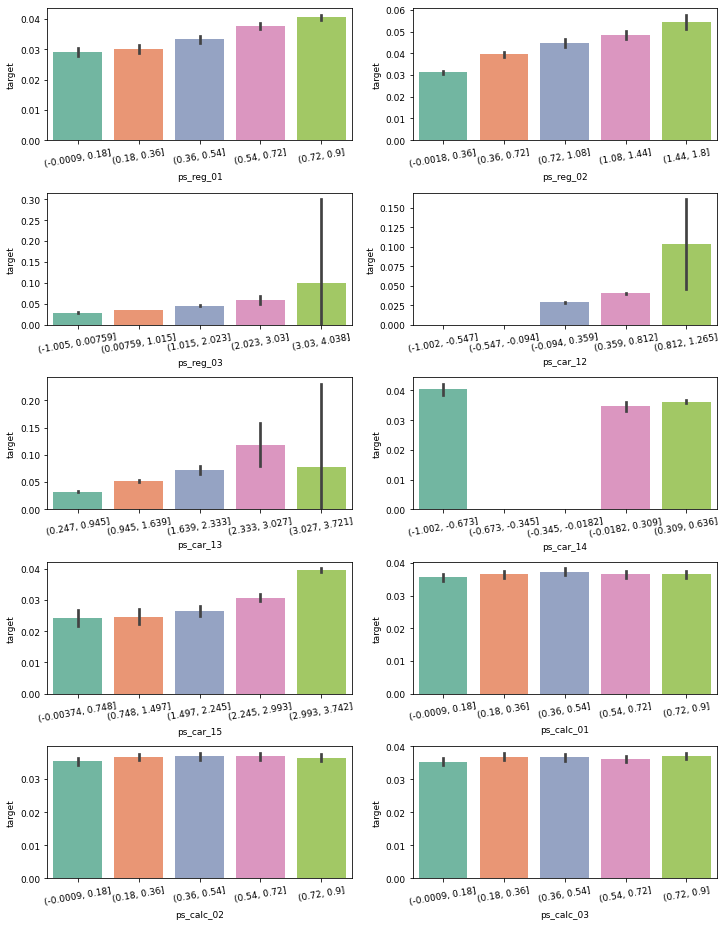

In [132]:
cont_features = summary[summary['데이터 종류']=='연속형'].index

plt.figure(figsize=(12,16))
grid = gridspec.GridSpec(5,2)
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for idx, cont_feature in enumerate(cont_features):
    train[cont_feature] = pd.cut(train[cont_feature],5)
    
    ax = plt.subplot(grid[idx])
    sns.barplot(x=cont_feature,y='target',data=train, palette='Set2', ax=ax)
    ax.tick_params(axis='x',labelrotation=10)

#### 제거해야 할 연속형 피처
- ps_calc_01 ~ ps_calc_03 => 구간별 타깃값 비율 차이가 없음

#### 연속형 피처2
- 피처 간 상관관계 파악하기      
=> 강한 상관관계를 보이는 두 피처가 존재할 경우 그 중 하나를 제거(다중공선성)

In [134]:
# 결측값 제거(결측값이 있을 경우 상관관계를 구하기 힘들기 때문)
train_copy = train_copy.dropna()

<AxesSubplot:>

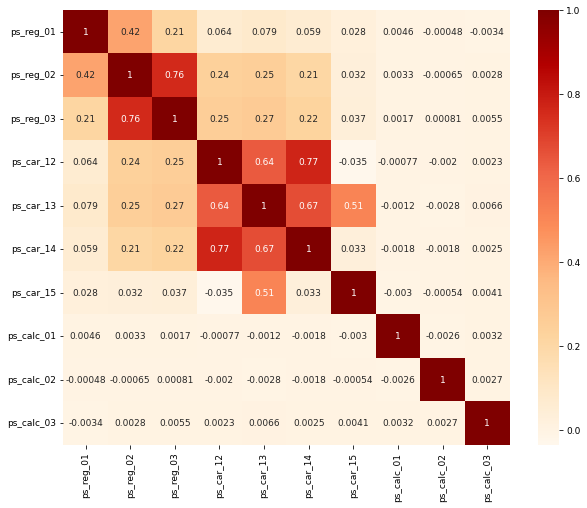

In [135]:
plt.figure(figsize=(10,8))
cont_corr = train_copy[cont_features].corr()
sns.heatmap(cont_corr, annot=True, cmap='OrRd')

#### 제거해야 할 피처
- ps_car_14 => ps_car_12와 강한 상관관계를 가짐. 이 때, ps_car_14를 제거할 경우와 제거하지 않았을 경우 제거했을 때 모델의 성능이 더 좋게 나오므로 제거!
- ps_reg_03 => ps_reg_02와 강한 상관관계를 가지지만 제거하지 않았을 경우 모델의 성능이 더 좋게 나오므로 제거하지 않음
- 결론 : 강한 상관관계를 가지더라도 제거하지 않았을 때 모델의 성능이 더 좋게 나오는 경우 해당 feature를 제거하지 말기!